In [2]:
import numpy as np
from collections import OrderedDict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer


In [3]:
class LRScheduledAdam(Optimizer):
    """
    Implements Adam algorithm with learning rate schedule.
    Modified based on hugging face implementation:
    https://huggingface.co/transformers/_modules/transformers/optimization.html#AdamW

    Parameters:
        params (:obj:`Iterable[torch.nn.parameter.Parameter]`):
            Iterable of parameters to optimize or dictionaries defining parameter groups.
        d_model (:obj:`int`):
            Dimension of embedding vector.
        warmup_steps (:obj:`int`):
            Steps for warmup before learning rate peaks.
        lr (:obj:`float`, `optional`, defaults to 0.):
            The learning rate to use.
        betas (:obj:`Tuple[float,float]`, `optional`, defaults to (0.9, 0.999)):
            Adam's betas parameters (b1, b2).
        eps (:obj:`float`, `optional`, defaults to 1e-6):
            Adam's epsilon for numerical stability.
        weight_decay (:obj:`float`, `optional`, defaults to 0):
            Decoupled weight decay to apply.
        correct_bias (:obj:`bool`, `optional`, defaults to `True`):
            Whether ot not to correct bias in Adam (for instance, in Bert TF repository they use :obj:`False`).
    """

    def __init__(
        self,
        params: Iterable[torch.nn.parameter.Parameter],
        d_model: int,
        warmup_steps: int,
        lr: float = 0.,
        betas: Tuple[float, float] = (0.9, 0.98),
        eps: float = 1e-9,
        correct_bias: bool = True,
    ):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[1]))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(eps))
        defaults = dict(
            lr=lr, betas=betas, eps=eps, correct_bias=correct_bias)
        super().__init__(params, defaults)
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def calc_step_size(self, step_num):
        '''udpate lr'''
        return (
            self.d_model**(-0.5) * min(step_num**(-0.5), step_num * self.warmup_steps**(-1.5))
        )

    def step(self, closure: Callable = None):
        """
        Performs a single optimization step.

        Arguments:
            closure (:obj:`Callable`, `optional`): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                exp_avg.mul_(beta1).add_(grad, alpha=1.0 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1.0 - beta2)
                denom = exp_avg_sq.sqrt().add_(group["eps"])

                group["lr"] = self.calc_step_size(state["step"])
                step_size = group["lr"]
                if group["correct_bias"]:  # No bias correction for Bert
                    bias_correction1 = 1.0 - beta1 ** state["step"]
                    bias_correction2 = 1.0 - beta2 ** state["step"]
                    step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(exp_avg, denom, value=-step_size)
        return loss

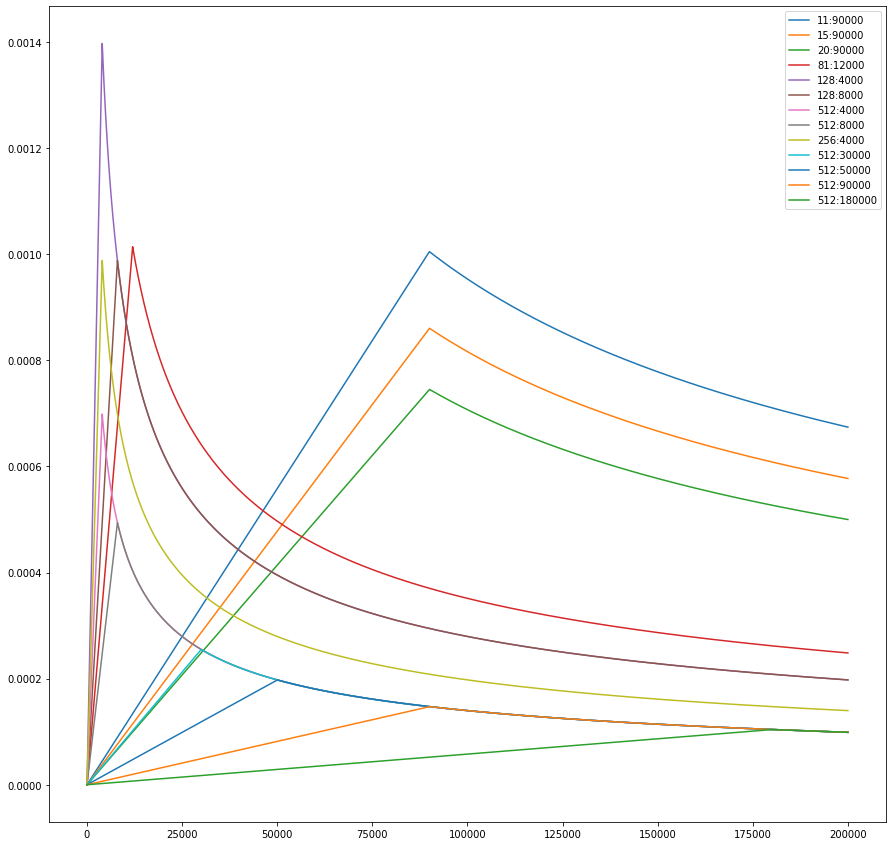

In [4]:
def plot_lr(myOpt):
    model = nn.Linear(2,3)
    opts = [myOpt(model.parameters(), 11, 90000),
            myOpt(model.parameters(), 15, 90000),
            myOpt(model.parameters(), 20, 90000),
            myOpt(model.parameters(), 81, 12000),
            myOpt(model.parameters(), 128, 4000),
            myOpt(model.parameters(), 128, 8000),
            myOpt(model.parameters(), 512, 4000), 
            myOpt(model.parameters(), 512, 8000),
            myOpt(model.parameters(), 256, 4000),
            myOpt(model.parameters(), 512, 30000),
            myOpt(model.parameters(), 512, 50000),
            myOpt(model.parameters(), 512, 90000),
            myOpt(model.parameters(), 512, 180000)
           ]
    plt.figure(figsize=(15,15))
    plt.plot(np.arange(1, 200000), [[opt.calc_step_size(i) for opt in opts] for i in range(1, 200000)])
    plt.legend(["11:90000", "15:90000", "20:90000", "81:12000", "128:4000", "128:8000", "512:4000", "512:8000", "256:4000", "512:30000", "512:50000", "512:90000", "512:180000"])

plot_lr(LRScheduledAdam)

In [7]:
1e7

10000000.0

In [ ]:
scale = 0.05

def plot_lr(myOpt):
    model = nn.Linear(2,3)
    opts = [
            myOpt(model.parameters(), 512, 100000)
           ]
    plt.figure(figsize=(15,15))
    plt.plot(np.arange(1, 1000000), [[opt.calc_step_size(i)*scale for opt in opts] for i in range(1, 1000000)])
    plt.legend(["512:12000"])

plot_lr(LRScheduledAdam)

In [5]:
1e-4

0.0001

In [2]:
0.0004 * 0.05

2e-05